<a href="https://colab.research.google.com/github/nishantkapps/aiml-projects/blob/main/Object_Detection_IOU_DrawBoundaryBox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import seaborn as sns
%matplotlib inline
import glob
import cv2
import tensorflow as tf
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import Callback
from IPython.display import SVG
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
# import the library
import warnings
warnings.filterwarnings('ignore')

## **Generate images and a bounding box**

In [ ]:
# Set parameters for the model
n_images = 5000
n_objects = 1
img_size = 16
min_obj_size = 1
max_obj_size = 8

## **Generate Training Set**

In [ ]:
def generate_training_set (n_images,
                           n_objects,
                           img_size,
                           min_obj_size,
                           max_obj_size):

  images=np.zeros((n_images,img_size, img_size))
  bbox=np.zeros((n_images,n_objects,4))

  for i in range(n_images):
    for j in range(n_objects):
      width, height = np.random.randint(min_obj_size, max_obj_size, size = 2)
      x = np.random.randint(0, img_size - width)
      y = np.random.randint(0, img_size - height)
      images[i, x : x + width, y : y + height] = 1.0
      bbox[i, j] = [x, y, width, height]

  return (images, bbox)

In [ ]:
images, bbox = generate_training_set(n_images,
                                     n_objects,
                                     img_size,
                                     min_obj_size,
                                     max_obj_size)
print("Image Shape", images.shape)
print("Bounding Box Shape", bbox.shape)

Image Shape (5000, 16, 16)
Bounding Box Shape (5000, 1, 4)


## **Visualize / Display the generated images**

In [ ]:
def display_image(index):
    plt.imshow(images[index].T, cmap = "binary", origin='lower', extent = [0, img_size, 0, img_size])
    for box in bbox[index]:
        plt.gca().add_patch(Rectangle((box[0], box[1]), box[2], box[3], ec = 'r', fc = 'none'))
    plt.xticks([])
    plt.yticks([])
    plt.show()

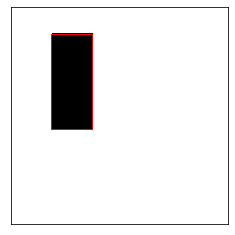

In [ ]:
display_image(np.random.randint(0,n_images))

In [ ]:
x=((images.reshape(n_images,-1))-np.mean(images))/np.std(images)

In [ ]:
y=bbox.reshape(n_images,-1)/img_size

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [ ]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3500, 256) (3500, 4) (1500, 256) (1500, 4)


## **Train the model (ANN)**

In [ ]:
model = Sequential()
model.add(Dense(256,input_dim=256))
model.add(Activation('relu'))
model.add(Dense(4))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               65792     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 66,820
Trainable params: 66,820
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')

In [ ]:
history = model.fit(x_train,y_train,epochs=20,validation_split=0.1)

Epoch 1/20
99/99 [==============================] - 4s 5ms/step - loss: 0.1689 - accuracy: 0.4546 - val_loss: 0.0561 - val_accuracy: 0.5514
Epoch 2/20
99/99 [==============================] - 0s 3ms/step - loss: 0.0356 - accuracy: 0.6235 - val_loss: 0.0354 - val_accuracy: 0.6543
Epoch 3/20
99/99 [==============================] - 0s 3ms/step - loss: 0.0216 - accuracy: 0.6825 - val_loss: 0.0273 - val_accuracy: 0.6914
Epoch 4/20
99/99 [==============================] - 0s 3ms/step - loss: 0.0150 - accuracy: 0.7149 - val_loss: 0.0203 - val_accuracy: 0.6829
Epoch 5/20
99/99 [==============================] - 0s 3ms/step - loss: 0.0121 - accuracy: 0.7270 - val_loss: 0.0186 - val_accuracy: 0.7429
Epoch 6/20
99/99 [==============================] - 0s 3ms/step - loss: 0.0102 - accuracy: 0.7683 - val_loss: 0.0177 - val_accuracy: 0.7086
Epoch 7/20
99/99 [==============================] - 0s 3ms/step - loss: 0.0079 - accuracy: 0.7759 - val_loss: 0.0151 - val_accuracy: 0.7800
Epoch 8/20
99/99 [==

## **Predict Bounding Box**

In [ ]:
y_pred = model.predict(x_test)
box_pred = y_pred*img_size
box_pred.shape

(1500, 4)

In [ ]:
def IOU(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    w_intersection = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_intersection = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_intersection <= 0 or h_intersection <= 0: # No overlap
        return 0
    I = w_intersection * h_intersection
    U = w1 * h1 + w2 * h2 - I # Union = Total Area - I
    return I / U

In [ ]:
iou = [IOU(y_test[i],y_pred[i]) for i in range(len(x_test))]

## **Visualization on validation set**

In [ ]:
def display(x, box, box_pred):
    index = np.random.randint(0, len(x))
    plt.imshow(x[index].reshape(16, 16).T, cmap = 'binary', origin = 'lower', extent = [0, img_size, 0, img_size])
    plt.gca().add_patch(Rectangle((box_pred[index][0], box_pred[index][1]),
                                      box_pred[index][2], box_pred[index][3],
                                      ec = 'r', fc = 'none'))
    plt.title("IOU: " + str(iou[index]))
    plt.xticks([])
    plt.yticks([])
    plt.show()

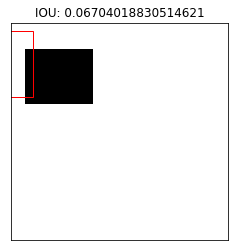

In [ ]:
display(x_test,y_test,box_pred)

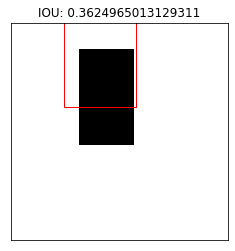

In [ ]:
display(x_test,y_test,box_pred)

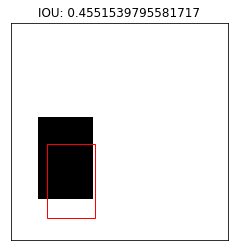

In [ ]:
display(x_test,y_test,box_pred)

In [ ]:
main_path = '/content/drive/MyDrive/datasets/'
image_path = os.path.join(main_path,"cat-iou.jpeg")

Source Image


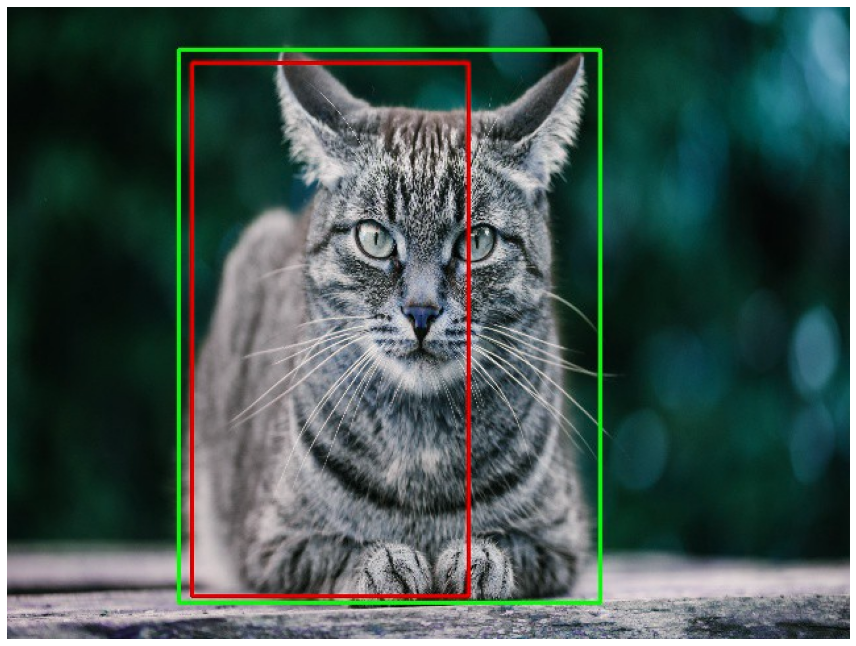

In [ ]:
print('Source Image')
plt.figure(figsize=(12,12))
img = cv2.imread(image_path)
plt.imshow(img)
plt.axis("off")
plt.tight_layout()
plt.show()